# PET simulation analysis

Run the simulation with `Gate mac/main.mac`

The output will be the files `output/pet2-Singles.root`, `output/pet2-Coincidences.root`

Vocabulary:
- events: (Geant4) primary particle tracked by the MC engine (source)
- track: (Geant4) every tracked particle is a track (including primary and secondaries)
- step: (Geant4) tracking is divided in step
- hits: (Gate) individual interaction inside a detector (with energy deposition)
- singles: combined hits in a given element (i.e. a single detector)
- coincidences: time associated singles
- trues: real, expected coincidences
- randoms: accidental coincidence
- scatters: coincidence events resulting from scattered photons inside the phantom
- prompts: total number of detected coincidences (sum of Trues + Randoms + Scatters)
- delays: estimated number of scattered coincidence

In [1]:
# some functions are defined in the file called pet_helpers.py
# they will be available with p.function_name()
# Example: 
import pet_helpers as p
p.hello()

Hello World


In [2]:
%matplotlib widget
import os
from pathlib import Path
# The following command display the current working directory (where jupyter has been launched)
# and select the output folder
cwd = os.getcwd()
folder = Path(os.path.join(cwd, './output_ref'))
if (not folder.is_dir()):
    print(f'ERROR: {folder} is not a folder.')
print(f'The Current Working Directory (CWD) is {cwd}')
print(f'The output folder is {folder}')

The Current Working Directory (CWD) is /Users/dsarrut/src/gate/dqprm/2022/gate-exercices/pet
The output folder is /Users/dsarrut/src/gate/dqprm/2022/gate-exercices/pet/output_ref


In [3]:
# print information about the simulation by reading the stat.txt file
stat = os.path.join(folder, 'stat.txt')
fs = open(stat, 'r').read()
n_events = int(p.get_stat_value(fs, '# NumberOfEvents = '))
t_start = int(p.get_stat_value(fs, '# StartSimulationTime        = '))
t_stop = int(p.get_stat_value(fs, '# StopSimulationTime         = '))
print(f'Number of simulated events (primaries): {n_events}')
print(f'Simulation timing: {t_start} to {t_stop} seconds')

Number of simulated events (primaries): 3680714
Simulation timing: 0 to 240 seconds


In [4]:
# opening the files
import uproot
def read_root_tree(filename):
    filename = os.path.join(folder, filename)
    f = uproot.open(filename)
    t = f['tree']
    print(f'Reading file {filename}')
    return t

The content of this root file is a set of data, organized in keys. For example, you can retrive all the particles information of the 'Singles' or of the 'Coincidences'.

In [5]:
#hits = read_root_tree('pet2.hits.root')
singles = read_root_tree('pet2.Singles.root')
coinc = read_root_tree('pet2.Coincidences.root')
delays = read_root_tree('pet2.delay.root')

Reading file /Users/dsarrut/src/gate/dqprm/2022/gate-exercices/pet/output_ref/pet2.Singles.root
Reading file /Users/dsarrut/src/gate/dqprm/2022/gate-exercices/pet/output_ref/pet2.Coincidences.root
Reading file /Users/dsarrut/src/gate/dqprm/2022/gate-exercices/pet/output_ref/pet2.delay.root


# Info: print the hits/singles/coincidences etc

In [6]:
# in the initial simulation the hits are not stored. 
# It can be enabled with the following macro:
# /gate/output/root/setRootHitFlag 1 in the file output.mac
# warning : it lead to a very large output file
#print('Number of hits:', len(hits))
print('Number of singles:', len(singles))
print('Number of coincidences:', len(coinc))
print('Number of delays', len(delays))
print('Singles keys: ')
for i in singles.keys():
    print(i, ' ', end='')

Number of singles: 25
Number of coincidences: 49
Number of delays 49
Singles keys: 
runID  eventID  sourceID  sourcePosX  sourcePosY  sourcePosZ  globalPosX  globalPosY  globalPosZ  gantryID  rsectorID  moduleID  submoduleID  crystalID  layerID  time  energy  comptonPhantom  comptonCrystal  RayleighPhantom  RayleighCrystal  comptVolName  RayleighVolName  rotationAngle  axialPos  

In [7]:
# Counts
# Cscat : scatter counts is the number of falsely located coincidence events resulting from gamma rays scattering inside the phantom
# Ctrue : is the number of true coincidences
# Crnd  : the number of random (accidental) coincidences
# Ctot  : Ctot = Cscat + Ctrue + Crnd is the total number of detected coincidences, sometimes called 'prompts'
# The 'delays' are the number of estimated random (because the real number of randoms cannot be known on a real system)
trues, scatters, randoms, Ctot = p.get_counts(coinc)
absolute_sensitivity = len(trues)/n_events
print(f'Number of detected coincidences  Ctot   {Ctot} ')
print(f'Number of scattered coincidences Cscat  {len(scatters)} ')
print(f'Number of true coincidences      Ctrue  {len(trues)} ')
print(f'Number of random coincidences    Crnd   {len(randoms)} ')
print(f'Number of estimated random       Delays {len(delays)}')
print(f'Absolute sensibility (Ctrues/events)    {absolute_sensitivity*100:.2f} %')

Number of detected coincidences  Ctot   68967 
Number of scattered coincidences Cscat  37388 
Number of true coincidences      Ctrue  31322 
Number of random coincidences    Crnd   257 
Number of estimated random       Delays 49
Absolute sensibility (Ctrues/events)    0.85 %


# Plot some information about the detection

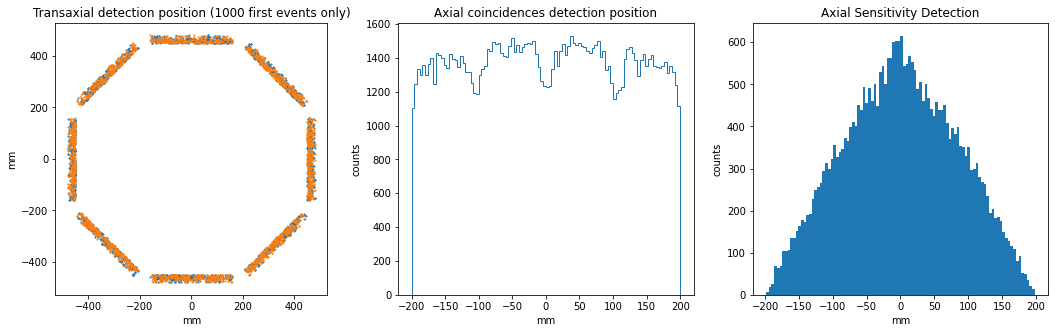

In [8]:
# plot1
import matplotlib.pyplot as plt
%matplotlib inline
fig1, ax1 = plt.subplots(1, 3, figsize=(18, 5))
slice_time = 100
p.plot_transaxial_position(ax1[0], coinc, slice_time)
p.plot_axial_detection(ax1[1], coinc)
p.plot_axial_sensitivity_detection(ax1[2], trues)

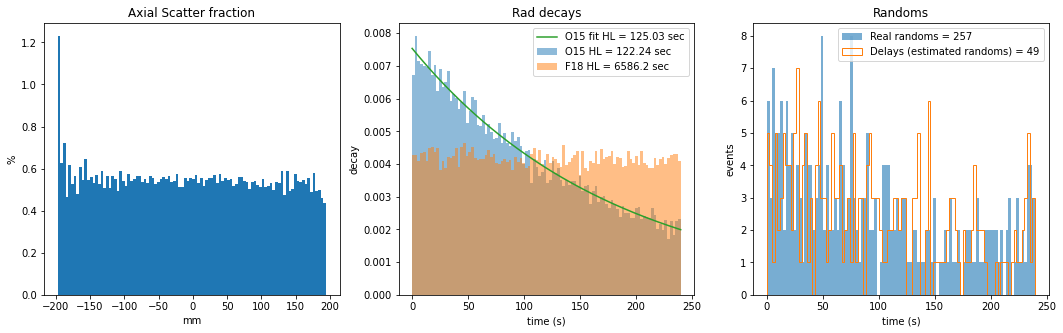

In [9]:
# plot2
fig2, ax2 = plt.subplots(1, 3, figsize=(18, 5))
p.plot_axial_scatter_fraction(ax2[0], coinc, scatters)
decayF18, decayO15 = p.get_decays(coinc)
p.plot_rad_decay(ax2[1], t_stop, decayO15, decayF18)
p.plot_randoms_delays(ax2[2], randoms, delays)

# Plot the energy  of the singles

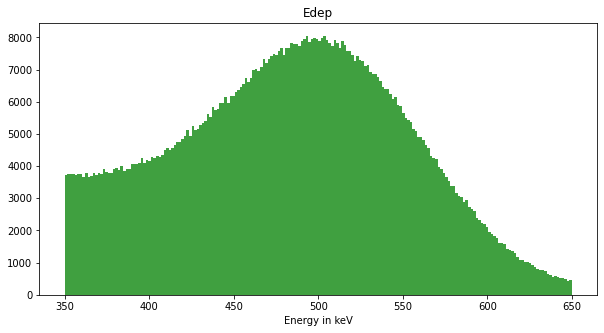

In [10]:
fig3, ax3 = plt.subplots(1, 1, figsize=(10, 5))
energy = singles.arrays()[b'energy']/0.001
n, bins, patches = ax3.hist(energy, 200, facecolor='green', alpha=0.75)
ax3.set_title('Edep')
ax3.set_xlabel('Energy in keV');

# Plot some LOR (Line Of Responses)

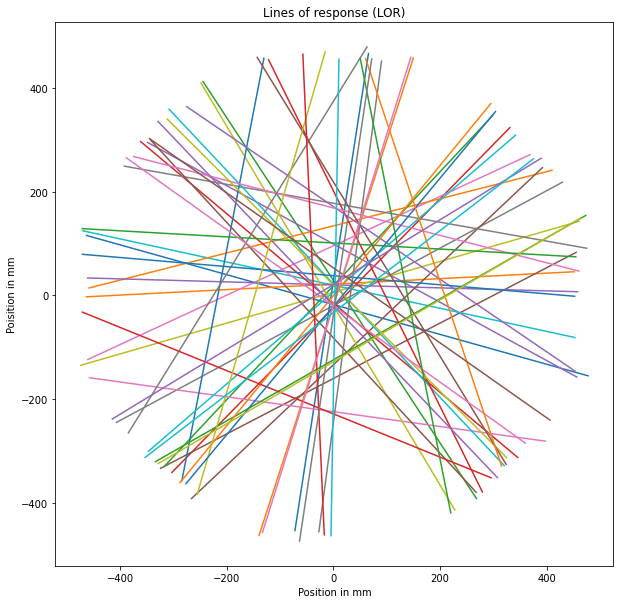

In [11]:
fig4, ax4 = plt.subplots(1, 1, figsize=(10, 10))
p.plot_LOR(ax4, coinc, 50)